In [3]:
%matplotlib inline
# %load_ext snakeviz
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7] # make a bigger default figure
plt.rcParams['font.size'] = 18

import json
import numpy as np
import pandas as pd
from pprint import pprint
from pygama import DataSet
# from pygama.utils import set_plot_style
# set_plot_style('root')

## 1. Explore the JSON metadata
Pygama currently uses a hand-edited JSON file to define:

* Paths to all files (in terms of the env var `$DATADIR`
* Processing parameters (chunk size)
* Important constants (digitizer clock speed, detector mass, etc.)

Hand-edited JSON files are very useful -- you can think of them as a big Python dictionary to store arbitrary parameters.  Calibration constants, run numbers, etc.

In [4]:
# load file
db_file = "testDB.json"
with open(db_file) as f:
    testDB = json.load(f)

In [5]:
print("-- Top-level information -- ")
for key in testDB:
    if not isinstance(testDB[key], dict):
        print(key, ":", testDB[key])

-- Top-level information -- 
loc_dir : $DATADIR/LNGS
raw_dir : $DATADIR/LNGS
tier_dir : $DATADIR/LNGS/pygama
digitizer : ORSIS3302Model
t1_prefix : t1_run
t2_prefix : t2_run
chunksize : 1000
clock : 100000000.0
rollover : 1
mass_note : (5.323 g/cm^3) * ((pi * 3.1^2 * 4.6) cm^3) / 1000
det_mass_kg : 0.739


In [6]:
print("-- Data set definitions -- ")
pprint(testDB["ds"])

-- Data set definitions -- 
{'0': ['204', '2019/03/18 thorium calibration, pos 2 (corner of rm)']}


## 2. pygama.DataSet

pygama uses the `DataSet` object to build a master list of runs and combine them into groups.
It uses the JSON DB file to keep track of file paths.
The current file uses the `$DATADIR` environment variable.

In [7]:
# can declare the DataSet either by "ds" number, or run numbers.

# ds = DataSet(0, 3, md=db_file, v=True) # can use a range of datasets

ds = DataSet(run=204, md=db_file, v=True) # can also use a list of run numbers

# print some of the DataSet attributes
print("raw dir : ", ds.raw_dir)
print("tier dir : ", ds.tier_dir)
print("t1 file prefix :", ds.t1pre)
print("t2 file prefix :", ds.t2pre)
print("current run list :", ds.runs)
print("current file paths :")
pprint(ds.paths)

raw dir :  /home/user/Data/LNGS
tier dir :  /home/user/Data/LNGS/pygama
t1 file prefix : t1_run
t2 file prefix : t2_run
current run list : [204]
current file paths :
{204: {'build_opt': 'conf1',
       't0_path': '/home/user/Data/LNGS/2019-3-18-BackgroundRun204',
       't1_path': '/home/user/Data/LNGS/pygama/t1_run204.h5',
       't2_path': '/home/user/Data/LNGS/pygama/t2_run204.h5'}}


In [ ]:
# load already processed dataframes

# t1df = ds.get_t1df() # currently loads the whole file.  not so useful

# t2df = ds.get_t2df() # this is more handy but could be improved upon

# timestamps = ds.get_ts() # need to process a run first

# runtime = ds.get_runtime() # need to process a run first

## 3. Tier 0 processing

Create a Tier 1 file from an ORCA input file ("Tier 0").

NOTE: The current Tier numbering may go out of date in the future.

In [8]:
# %%prun
# %%snakeviz
from pygama.io.tier0 import ProcessTier0

# settings
nevt = 50000
overwrite = True
test = False
verbose = True

for run in ds.runs:

    t0_file = ds.paths[run]["t0_path"]
    t1_file = ds.paths[run]["t1_path"]
    if t1_file is not None and overwrite is False:
        continue

    conf = ds.paths[run]["build_opt"]
    opts = ds.runDB["build_options"][conf]["tier0_options"]

    if test:
        print("test mode (dry run), processing Tier 0 file:", t0_file)
        continue

    if nevt != np.inf:
        nevt = int(nevt)

    ProcessTier0(
        t0_file,
        verbose=verbose,
        output_dir=ds.tier_dir,
        overwrite=overwrite,
        n_max=nevt,
        settings=opts)

Starting pygama Tier 0 processing ...
  Input file: /home/user/Data/LNGS/2019-3-18-BackgroundRun204
Total file size: 1505.023 MB
Run number: 204
Data IDs present in this header are:
    4: OR1DHistoDecoder
    5: ORRunDecoderForRun
    1: ORSIS3302DecoderForEnergy
    3: ORSIS3302DecoderForLostData
    2: ORSIS3302DecoderForMca
pygama will run these decoders:
    1: ORSIS3302DecoderForEnergy
Overwriting existing file...
Beginning Tier 0 processing ...
Progress : [####----------------] 20.1% Writing ORSIS3302DecoderForEnergy
done.  last packet ID: 50000
Writing ORSIS3302DecoderForEnergy
Progress : [####################] 100.0% Done...
Wrote: Tier 1 File:
    /home/user/Data/LNGS/pygama/t1_run204.h5
FILE INFO:
['/ORSIS3302DecoderForEnergy', '/ORSIS3302Model']
File size: 249.199 MB
Time elapsed: 29.52 sec
Done.



## 4. Tier 1 processing (DSP)

This can be run in a few different ways:

* Batch mode, with multiprocessing.  Right now this is slow at NERSC, but reasonably fast on local machines
* Test mode.  By placing `"test":1` in the arguments of a Processor, we get a diagnostic (interactive) plot.

I prefer to do this by editing the JSON file directly, but for this tutorial, I'll illustrate how the processor list can be treated as a Python dictionary.

In [12]:
# show our processor list
t1_opts = ds.runDB["build_options"][conf]["tier1_options"]

# modify one of the processors to have the test argument.  Can also directly edit the JSON file
t1_opts['ftp']["test"] = 1

# undo the modification
# del(t1_opts["pz"]["test"]) 

pprint(t1_opts)

{'blsub': {},
 'clk': 100000000.0,
 'current': {'sigma': 5, 'wfin': 'wf_blsub', 'wfout': 'wf_current'},
 'dcr': {'wfin': 'wf_savgol'},
 'fit_bl': {'ihi': 600, 'order': 1},
 'ftp': {'test': 1},
 'get_max': [{'wfin': 'wf_etrap'},
             {'wfin': 'wf_atrap'},
             {'wfin': 'wf_current'},
             {'wfin': 'wf_savgol'}],
 'notch': {'Q': 1, 'f_notch': 30000000.0},
 'pz': {'decay': 82},
 'savgol': {'order': 2, 'wfin': 'wf_blsub', 'wfout': 'wf_savgol', 'window': 47},
 'timepoint': {'pct': [5, 10, 50, 100], 'wfin': 'wf_blsub'},
 'trap': [{'decay': 72,
           'flat': 2.5,
           'rise': 4,
           'wfin': 'wf_blsub',
           'wfout': 'wf_etrap'},
          {'fall': 2,
           'flat': 0.1,
           'rise': 0.04,
           'wfin': 'wf_notch',
           'wfout': 'wf_atrap'}]}


In [13]:
# %%snakeviz
# %%prun
from pygama.dsp.base import Intercom
from pygama.io.tier1 import ProcessTier1

# settings
nevt = 1000
ioff = 0 # starting entry number
overwrite = True
verbose = True
test = False # dry run
chunksize=500

# set to False when one of the processors is in test mode
# or when we want to profile the code with snakeviz
multiproc = True

# reload the DataSet
ds = DataSet(run=204, md=db_file, v=True) # can also use a list of run numbers

t1_opts = ds.runDB["build_options"][conf]["tier1_options"]
# t1_opts['ftp']["test"] = 1

# undo the modification
# del(t1_opts["ftp"]["test"]) 

for run in ds.runs:

    t1_file = ds.paths[run]["t1_path"]
    t2_file = ds.paths[run]["t2_path"]
    if t2_file is not None and overwrite is False:
        continue
        
    if test:
        print("test mode (dry run), processing Tier 1 file:", t1_file)
        continue
        
    conf = ds.paths[run]["build_opt"]
    
    proc = Intercom(t1_opts)
    
    # run DSP
    ProcessTier1(
        t1_file,
        proc,
        output_dir=ds.tier_dir,
        overwrite=overwrite,
        verbose=verbose,
        multiprocess=multiproc,
        nevt=nevt,
        ioff=ioff,
        chunk=chunksize)

Starting pygama Tier 1 processing ...
  Date: 2019-05-28 15:50:22.760310
  Input file: /home/user/Data/LNGS/pygama/t1_run204.h5
  Size:  249.199 MB
Overwriting existing file...
Processing data from digitizer: ORSIS3302DecoderForEnergy
Found 49995 rows, splitting into 100 chunks
Progress : [##------------------] 12.0% Estimated time to completion: 0.86 min
Progress : [##------------------] 12.0% Estimated time to completion: 1.03 min
Progress : [##------------------] 12.0% Estimated time to completion: 1.05 min
Progress : [##------------------] 12.0% Estimated time to completion: 1.10 min
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Progress : [####################] 100.0% Done...
Writing Tier 2 File:
   /home/user/Data/LNGS/pygama/t2_run204.

## 5. Tier 2 analysis

Once we have a Tier 2 file, we can do a lot of "whole-run" analysis.  

Here we'll show:

* Timestamp rollover correction
* Rough energy calibration
* 2615-keV peak resolution

For reference, the data columns in this "test" Tier 2 file are:
```
['channel' 'energy' 'energy_first' 'ievt' 'packet_id' 'timestamp' 'ts_hi'
 'bl_rms' 'bl_p0' 'bl_p1' 'etrap_max' 'etrap_imax' 'atrap_max'
 'atrap_imax' 't0' 't_ftp' 'e_ftp']```
 
To compare to "standard" analysis parameters:

* `e_ftp : trapENF`, recommended energy estimator (Majorana fixed time pickoff algorithm)
* `current_max : A` (multisite discrim.)
* `tslope_pz : DCR` tail slope measurement, run on pole-zero corrected waveforms
 
Let's start by looking at the timestamps and rollover of the SIS3302 ...

runtime: 119.31 sec


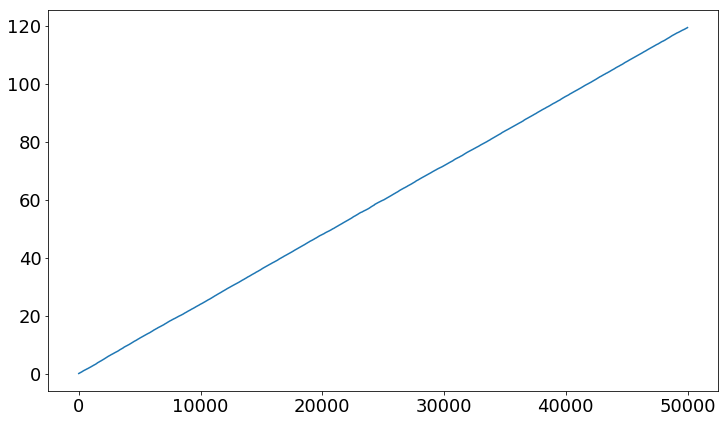

In [17]:
"""
Retrieve the DataFrame from the t2 file.  
TODO: add more convenience functions (incl. event limit)
"""
# reload the DataSet
ds = DataSet(run=204, md=db_file, v=True) # can also use a list of run numbers

# get the Tier 2 dataframe
t2df = ds.get_t2df() 

# get the runtime in seconds, accounting for rollover.
# NOTE: if the "nevt" limit is set, this can give a reduced runtime than the actual run

rollover = True

timestamps = ds.get_ts(rollover=rollover)
plt.plot(timestamps)

runtime = ds.get_runtime(rollover=rollover)
print("runtime: {:.2f} sec".format(runtime))

Tier 1 DataFrame columns:
Index([       'index',      'channel',       'energy', 'energy_first',
               'ievt',    'packet_id',    'timestamp',        'ts_hi',
              'ts_lo',              0,
       ...
                 2990,           2991,           2992,           2993,
                 2994,           2995,           2996,           2997,
                 2998,           2999],
      dtype='object', length=3009)


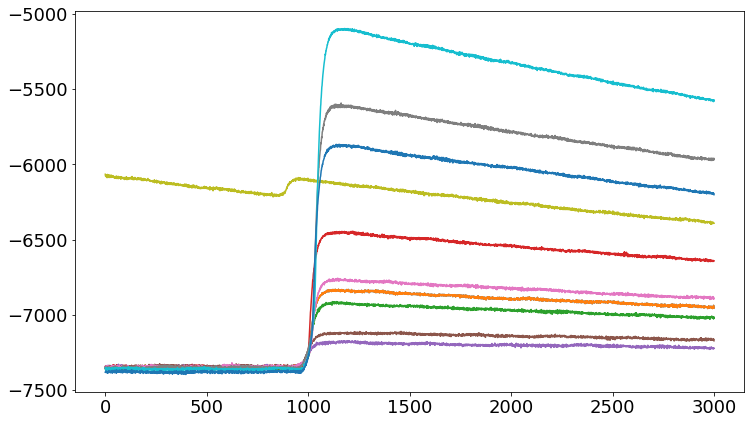

In [18]:
"""
Show waveforms from the Tier 1 file.
NOTE: pygama.DataSet has a convenience function "get_t1df" but is undeveloped.
If there are too many waveforms, we have to use a lot of memory.
For now, let's show an example of accessing the file directly with pandas.read_hdf.
"""
# t1df = ds.get_t1df() # not ready for use yet

# remind ourselves where the file is stored using DataSet
# we know it's run 204 already, but use DataSet's members anyway
# pprint(ds.paths)
run = ds.runs[0]
t1_file = ds.paths[run]["t1_path"]

# remind ourselves the name of the HDF5 group key using the DB.
# pprint(testDB['build_options'])
t1_key = testDB['build_options']['conf1']['tier0_options']['digitizer']

# load a small dataframe
t1df = pd.read_hdf(t1_file, stop=200, key=t1_key)
t1df.reset_index(inplace=True) # required step -- until we fix pygama 'append' bug

print("Tier 1 DataFrame columns:")
print(t1df.columns)

# scrub the non-wf columns and create a 2d numpy array
icols = []
for idx, col in enumerate(t1df.columns):
    if isinstance(col, int):
        icols.append(col)
wfs = t1df[icols].values

ts = np.arange(0, len(wfs[0]), 1)

# one waveform
plt.plot(ts, wfs[0])

# 50 waveforms
for row in wfs[:10]:
    plt.plot(ts, row)

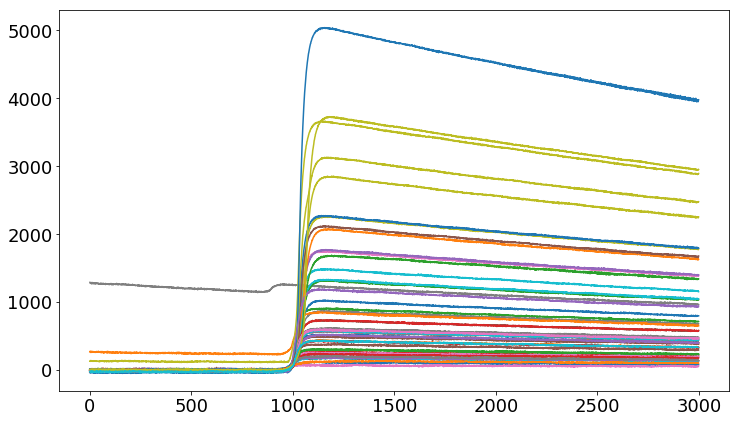

In [19]:
# for fun, let's load the T2 dataframe and subtract the baselines manually
t2df = ds.get_t2df() 

# correct a single waveform
iwf = 1
p0 = t2df["bl_p0"].iloc[1]
p1 = t2df["bl_p1"].iloc[1]
ts = np.arange(len(wfs[1]))
wf = wfs[1] - (p0 + ts * p1)

# plt.plot(ts, wf)

# correct the whole block at once
wfbl = wfs - (p0 + ts * p1)

for i in range(50):
    plt.plot(ts, wfbl[i])
    # plt.plot(ts[:500], wfbl[i][:500])

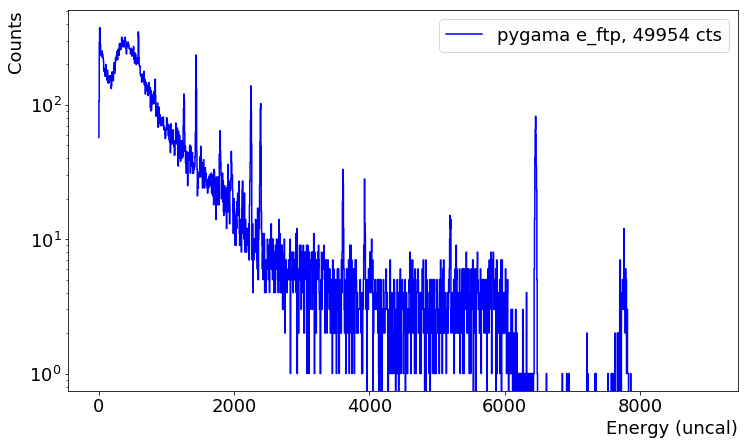

In [20]:
"""
show an energy spectrum using e_ftp.
method 1: direct use of np.histogram
"""
arr = t2df["e_ftp"]

xlo, xhi, xpb = 0, 9000, 5
nb = int((xhi-xlo)/xpb)
h, b = np.histogram(arr, nb, (xlo, xhi))
h = np.concatenate((h, [0])) # annoying -- have to add an extra zero

plt.semilogy(b, h, ls='steps', lw=1.5, c='b', label="pygama e_ftp, {} cts".format(sum(h)))
plt.xlabel("Energy (uncal)", ha='right', x=1)
plt.ylabel("Counts", ha='right', y=1)
plt.legend()
plt.show()

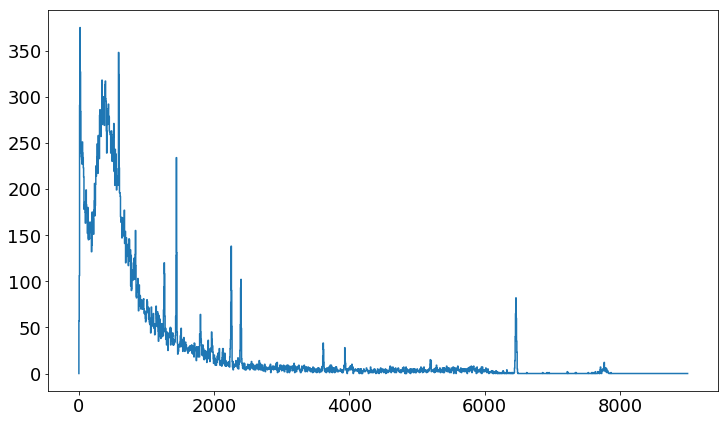

In [21]:
"""
show an energy spectrum using e_ftp.
method 2: try some pygama convenience functions
"""
from pygama.analysis.histograms import *

arr = t2df["e_ftp"]

ph, pb,_ = get_hist(arr, range=(0,9000), dx=5)

plot_hist(ph, pb)

chi2 fit:
mu = 6462.33 +/- 0.52
sigma = 8.27 +/- 0.44
A = 300. +/- 18.

poissonLL step fit:
mu = 6463. +/- 12.
sigma = 12.14 +/- 0.88
step = 0.23 +/- 0.33
A = 3.3e+02 +/- 1.0e+02



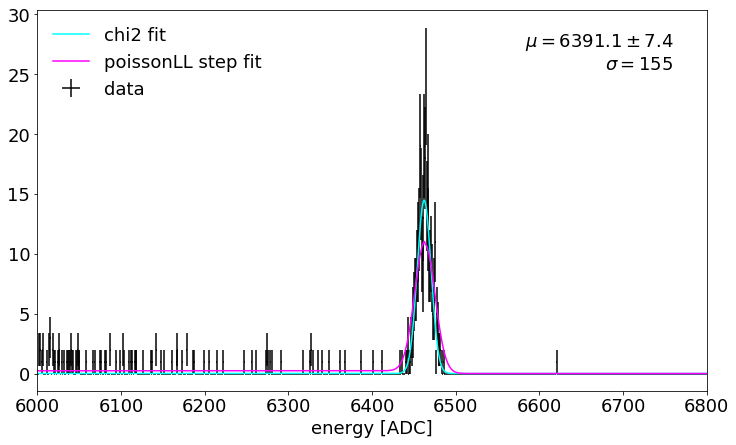

In [22]:
# try out some pygama fitting routines from Jason
import pygama.analysis.calibration as pgc
import pygama.analysis.histograms as pgh
import pygama.utils as pgu

# make the hist
arr = t2df["e_ftp"]
xlo, xhi, xpb = 6000, 7000, 1
hist, bins, var = pgh.get_hist(arr, range=(xlo, xhi), dx=xpb)

# use a style file and set x title, range
# pgu.set_plot_style('root')
# plt.figure(figsize=(8,6))
pgh.plot_hist(hist, bins, var, label="data", show_stats=True, color='black')
plt.xlabel("energy [ADC]")
plt.gca().set_xlim(6000, 6800)

# fit to a gaussian with a standard chi2 fit
pars, cov = pgc.fit_hist(pgc.gauss, hist, bins, var=var, guess=[6450, 10, 100])
pgu.print_fit_results(pars, cov, pgc.gauss, title="chi2 fit")
pgu.plot_func(pgc.gauss, pars, npx=1000, label="chi2 fit", color='cyan')

def gauss_plus_step(x, mu, sigma, step, A=1):
    return pgc.gauss(x, mu, sigma, A) + np.where(x<mu, step, 0)

nbnd = (-np.inf, np.inf)
pos = (0, np.inf)
pars, cov = pgc.fit_hist(gauss_plus_step, hist, bins, var=var, guess=[6450, 10, 0.1, 100], bounds=[nbnd,pos,pos,pos], poissonLL=True)
pgu.print_fit_results(pars, cov, gauss_plus_step, title="poissonLL step fit")
pgu.plot_func(gauss_plus_step, pars, npx=1000, label="poissonLL step fit", color='magenta')

plt.legend(frameon=False, loc='upper left')

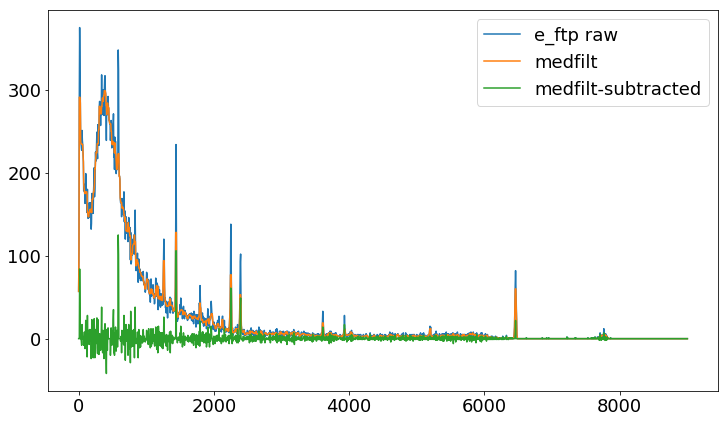

In [23]:
"""
now let's try calibrating the e_ftp spectrum.
NOTE: 
the code below is from pygama/experiments/mj60/bkg_calibration.py (M. Stortini, UW)
but soon the code will be polished and integrated into pygama/pygama/analysis/calibration.py
"""
pks_lit = [609.3, 1460.8] 

from scipy.signal import medfilt

hmed = medfilt(h, 5)
hpks = h - hmed # subtract out the smoothed spectrum

plt.plot(b, h, label="e_ftp raw")
plt.plot(b, hmed, label="medfilt")
plt.plot(b, hpks, label="medfilt-subtracted") 
plt.legend()

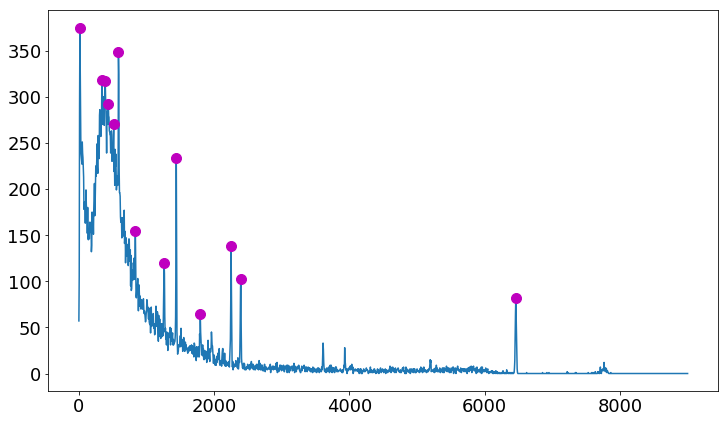

In [24]:
# run pygama's "peakdet" function to automatically identify the peaks

maxes, mins = pgu.peakdet(h, 40, b)

plt.plot(b, h)
# plt.plot(b, hpks)

for x,y in maxes:
    plt.plot(x, y, "m.", ms=20)